# PINN - Physics-informed neural networks (Redes neurais informadas pela Física)

Primeiramente, deve-se importar as bibliotecas necessárias:

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## Definição do problema

Será utilizado o método PINN para solucionar 2 problemas relacionados a um oscilador harmônico subamortecido.

<img src="oscillator.gif" width="500">

Da teoria clássica de Vibrações, o deslocamento $u(t)$ do oscilador em função do tempo é dado pela equação diferencial:

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~,
$$

onde $m$ é a massa do oscilador, $\mu$ é o coeficiente de atrito e $k$ a constante da mola. Em um sistema subamortecido, em que o atrito reduz lentamente a oscilação, as seguintes relações são válidas:

$$
\delta < \omega_0~,~~~~~\mathrm{onde}~~\delta = \dfrac{\mu}{2m}~~\mathrm{e}~~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$

Considerando-se como condições iniciais ($t = 0$) do problema um deslocamento unitário e velocidade nula:

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$

Dessa forma, a solução analítica do problema é dada por:

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~, 
$$

sendo $\phi = \arctan(\dfrac{-\delta}{\omega})$ o ângulo de fase e $A = \dfrac{1}{2 \cos(\phi)}$ a amplitude do sistema.

## Algoritmo PINN

De posse do modelo matemático, pode-se implementar a solução por PINN para medida de comparação. Para isso, será utilizada a linguagem Python e também a biblioteca de *machine learning* Pytorch.

Abaixo, serão definidas algumas funções auxiliares e uma função para calcular a solução analítica do problema:

In [3]:
# Solução analítica do problema de oscilador harmônico subamortecido
# Parâmetros de entrada:
# delta (coeficiente de amortecimento do sistema) = mu (coeficiente de atrito do amortecedor) / 2 * m (massa do sistema)
# w0 (frequência natural) = ( k (rigidez do sistema) / m (massa do sistema) )^(1/2)
# t (variável tempo)
def analitico(delta, w0, t):

    # Verifica se o sistema é subamortecido
    assert delta < w0

    # Define as constantes com numpy
    # Frequência amortecida
    w = np.sqrt(w0**2 - delta**2)

    # Ângulo de fase
    phi = np.arctan(-delta / w)

    # Amplitude
    A = 1 / (2 * np.cos(phi))
    
    # Define a função de deslocamento com pytorch (necessário usar para calcular os gradientes depois)  
    u = torch.exp(-delta * t) * 2 * A * torch.cos(phi + w * t)

    # Retorna o deslocamento
    return u

Agora, criando a rede neural com o Pytorch:

In [4]:
# Define uma classe que herda as características de nn.Module, a classe base de redes neurais do Pytorch
class FCN(nn.Module):

    # Inicializa a classe a partir dos parâmetros:
    # N_INPUT: número de entradas da rede
    # N_OUTPUT: número de saídas da rede
    # N_HIDDEN: número de neurônios em cada camada da rede
    # N_LAYERS: número de camadas da rede    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()

        # Define a função de ativação, no caso, tangente hiberbólica
        activation = nn.Tanh

        # Faz a conexão sequencial entre os elementos da rede neural
        # Mapeia linearmente entre parâmetros
        # Utiliza a função de ativação tanh

        # fcs - mapeamento entre as entradas e primeira camada
        # fch - mapeamento entre as camadas da rede
        # fce - mapeamento entre a última camada e a saída
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    # Define o "forward pass", ou seja, passa a entrada x por todos os contâineres criados e devolve a saída
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

## Problema 1 - Direto - Simular o sistema através de um PINN

No primeiro problema a ser resolvido, o sistema será simulado através de uma rede neural PINN. São especificados como dados de entrada a equação diferencial do problema e as condições iniciais, a partir das quais será estimado um deslocamento $u(t)$.

O PINN é treinado com o objetivo de minimizar a função de perda $\mathcal{L}$ abaixo:

$$
\mathcal{L}(\theta)= (u_{\mathrm{PINN}}(t=0;\theta) - 1)^2 + \lambda_1 \left(\frac{d\,u_{\mathrm{PINN}}}{dt}(t=0;\theta) - 0\right)^2 + \frac{\lambda_2}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2 ,
$$

onde $u_{\mathrm{PINN}}$ é a solução estimada, $\theta$ são os parâmetros livres da rede neural, e $\lambda_1$ e $\lambda_2$ são hiperparâmetros, utilizados para balancear os termos da função de peso e garantir um treino estável.

Os dois primeiros termos da função $\mathcal{L}$ são chamados de Perda de Contorno e buscam garantir que o PINN respeite as condições iniciais do problema. Já o último termo é chamado de Perda Física, e busca garantir que a equação diferencial seja respeitada em um conjunto de pontos de treino ao longo do domínio.

Será considerado no problema que $\delta=2$, $\omega_0=20$, e que $t \in [0,1]$.

Criada a classe para a rede neural, deve-se defini-la e treiná-la através da função de Perda.

In [5]:
# Cria um seed no pytorch para que os números aleatórios gerados sejam sempre os mesmos
# Isso garante a reproducibilidade do código
torch.manual_seed(123)

# Define a rede neural especificando todos os parâmetros
# N_INPUT = 1 (1 entrada); N_OUTPUT = 1 (1 saída); N_HIDDEN = 32 (32 neurônios por camada); N_LAYERS = 3 (3 camadas na rede)   
pinn = FCN(1,1,32,3)

# Define pontos de contorno para a função Perda de Contorno
# Define um ponto de contorno t = 0 (condição inicial) através de um tensor unitário (1 linha e 1 coluna)
# O parâmetro requires_grad_(True) indica que sejam calculadas derivadas desse tensor
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# Define pontos de treino no domínio para a função Perda Física
# Define 30 pontos entre 0 e 1 para calcular a Perda Física a partir da equação diferencial
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# Define os parâmetros físicos do sistema
delta = 2
w0 = 20
mu = 2 * delta
k = w0**2

# Cria 300 pontos entre 0 e 1 para teste da rede neural
t_test = torch.linspace(0,1,300).view(-1,1)

Agora, gerando a solução exata e a solução por PINNs para comparação:

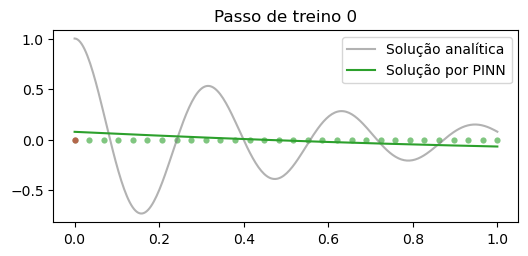

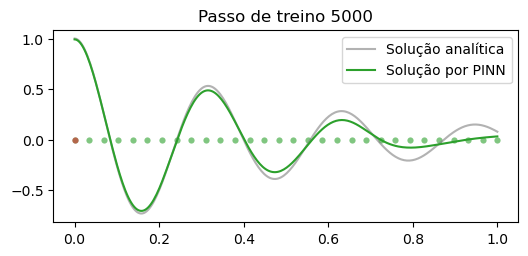

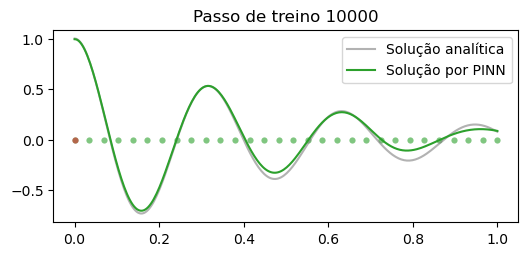

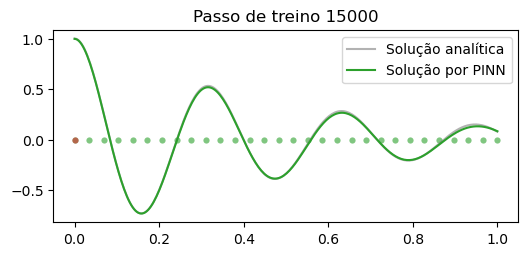

In [6]:
# Roda a solução analítica para todos os pontos de teste
u_analitico = analitico(delta, w0, t_test)

# Cria um otimizador ADAM (Adaptive Moment Estimation) 
# Os parâmetros do sistema (pesos e viéses) são otimizados 
# Definida uma taxa de aprendizado de 10^-3, que define o tamanho do passo em direção aos mínimos da função de Perda
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-3)

# Inicializa um loop de treino com 15.001 iterações
for i in range(15001):

    # Inicializa o gradiente do otimizador em zero
    optimiser.zero_grad()
    
    # Define hiperparâmetros lambda para balancear o efeito das funções de perda
    # Perda de contorno
    lambda1 = 1e-1
    # Perda física
    lambda2 = 1e-4
    
    # Calcula a função de Perda de Contorno ao definir as condições iniciais do problema
    # Previsão da rede neural no contorno (t = 0)
    u = pinn(t_boundary)

    # Condição 1:
    # Força que o deslocamento em t = 0 seja igual a 1 (condição inicial)
    loss1 = (torch.squeeze(u) - 1)**2

    # Realiza derivação automática pelo Pytorch da função deslocamento no contorno (t = 0)
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]

    # Condição 2:
    # Força que a velocidade em t = 0 seja igual a zero (condição inicial) 
    loss2 = (torch.squeeze(dudt) - 0)**2
    
    # Calcula a função de Perda Física através da equação diferencial conhecida
    # Previsão da rede neural nos pontos de treino
    u = pinn(t_physics)

    # Realiza derivação automática pelo Pytorch da função deslocamento nos pontos de treino
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]

    # Realiza derivação automática pelo Pytorch da função velocidade nos pontos de treino
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]

    # Força o atendimento da equação diferencial do problema
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)
    
    # Calcula a função de Perda global (contorno + física)
    loss = loss1 + lambda1 * loss2 + lambda2 * loss3

    # Realiza o método de "backpropagation" para calcular as derivadas automáticas e otimizar os parâmetros do sistema usando o otimizador
    loss.backward()
    optimiser.step()
    
    # Gera gráficos dos resultados a cada 5000 iterações
    if i % 5000 == 0: 
        
        # Utiliza a rede neural para prever o deslocamento nos pontos de teste
        u = pinn(t_test).detach()

        # Gera gráficos de dispersão para os pontos de treino e para o ponto de contorno
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0], 
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0], 
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        
        # Gera gráficos para comparação da solução analítica com a solução por PINN
        plt.plot(t_test[:,0], u_analitico[:,0], label="Solução analítica", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="Solução por PINN", color="tab:green")
        plt.title(f"Passo de treino {i}")
        plt.legend()
        plt.show()

## Problema 2 - Inversão - Encontrar um parâmetro do sistema através de dados conhecidos

Diferentemente do outro problema, onde tinham-se condições de contorno e a equação diferencial do problema e o PINN foi treinado para modelar o comportamento do sistema, agora têm-se à disposição um conjunto de observações do deslocamento do oscilador (que contém ruído). Deseja-se utilizá-las para obter um parâmetro desconhecido do sistema, no caso, o coeficiente de atrito $\mu$.

Logo, a função de perda deve ser alterada para o modelo abaixo:

$$
\mathcal{L}(\theta, \mu)= \frac{1}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2 + \frac{\lambda}{M} \sum^{M}_{j} \left( u_{\mathrm{PINN}}(t_{j};\theta) - u_{\mathrm{obs}}(t_{j}) \right)^2
$$

O primeiro termo é a Perda Física, definida da mesma forma que no problema anterior. O segundo termo é da Perda de Dados, que busca garantir que a solução gerada pelo PINN atenda as observações disponíveis.

Observa-se que além dos parâmetros livres do sistema, têm-se também como variável o coeficiente $\mu$.

Partindo para a implentação do algoritmo, deve-se gerar os dados do sistema com ruído incluído. Em uma aplicação prática, esses seriam os dados experimentais obtidos:

Valor verdadeiro de mu: 4


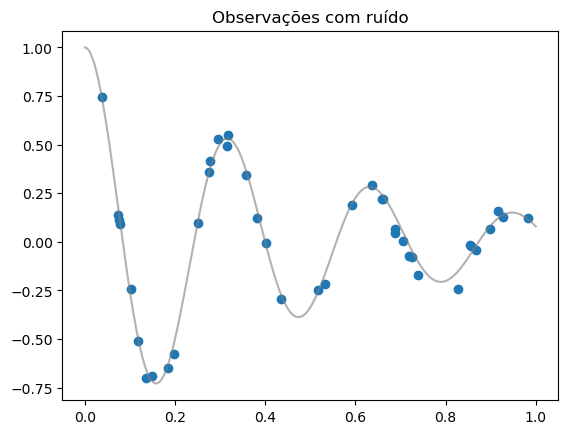

In [7]:
# Definir um seed para reproducibilidade
torch.manual_seed(123)

# Vamos criar os dados com ruído a partir de valores basais, para que possa ser feito um comparativo do modelo posteriormente
delta = 2
w0 = 20
print(f"Valor verdadeiro de mu: {2*delta}")

# Cria um conjunto de 40 pontos aleatórios de tempo
t_obs = torch.rand(40).view(-1,1)

# Cria um conjunto correspondente de deslocamentos a partir do valor analítico, considerando ruído aleatório
u_obs = analitico(delta, w0, t_obs) + 0.04*torch.randn_like(t_obs)

# Produz um gráfico do comportamento exato e também das observações aleatórias geradas
plt.figure()
plt.title("Observações com ruído")
plt.scatter(t_obs[:,0], u_obs[:,0])
t_test, u_exact = torch.linspace(0,1,300).view(-1,1), analitico(delta, w0, t_test)
plt.plot(t_test[:,0], u_exact[:,0], label="Solução analítica", color="tab:grey", alpha=0.6)
plt.show()

Agora, novamente será criada a rede neural por PINNs, para tentar modelar o sistema e também encontrar o coeficiente de atrito desconhecido.

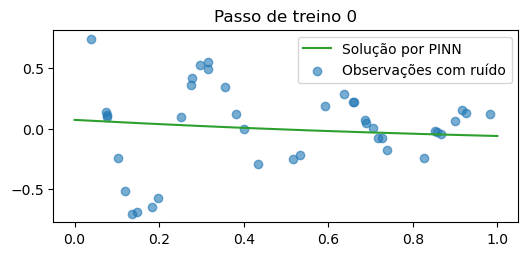

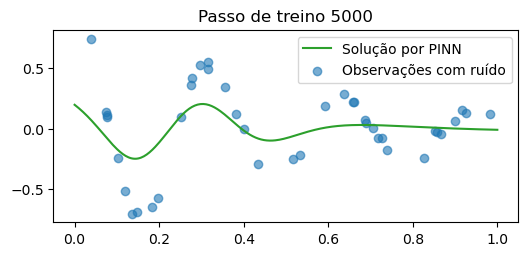

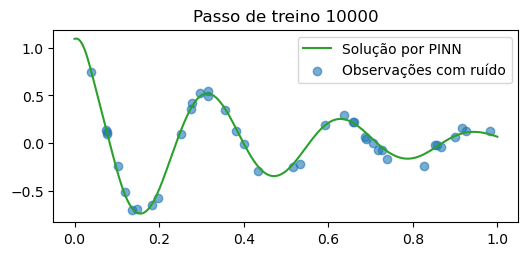

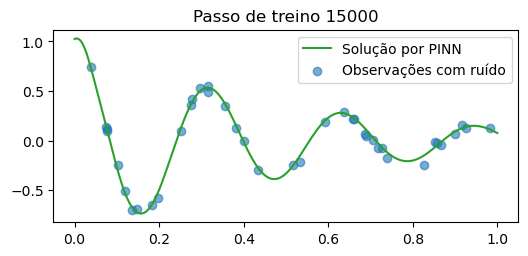

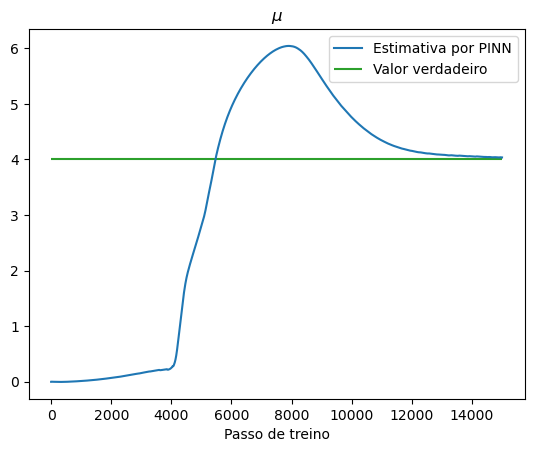

In [8]:
# Definir um seed para reproducibilidade
torch.manual_seed(123)

# Define a rede neural especificando todos os parâmetros
# N_INPUT = 1 (1 entrada); N_OUTPUT = 1 (1 saída); N_HIDDEN = 32 (32 neurônios por camada); N_LAYERS = 3 (3 camadas na rede)   
pinn = FCN(1,1,32,3)

# Define pontos de treino no domínio para a função Perda Física
# Define 30 pontos entre 0 e 1 para calcular a Perda Física a partir da equação diferencial
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# Define os parâmetros físicos do sistema
# mu não é conhecido
delta = 2
w0 = 20
_ = 2 * delta
k = w0**2

# Define mu como um parâmetro a ser treinado
mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))

# Cria um vetor em branco para adicionar os valores calculados pela rede neural
mus = []

# Cria um otimizador ADAM (Adaptive Moment Estimation) adicionando mu como um parâmetro
optimiser = torch.optim.Adam(list(pinn.parameters())+[mu],lr=1e-3)

# Inicializa um loop de treino com 15.001 iterações
for i in range(15001):

    # Inicializa o gradiente do otimizador em zero
    optimiser.zero_grad()
    
    # Define hiperparâmetros lambda para balancear o efeito das funções de perda
    # Perda física
    lambda1 = 1e4
    
    # Calcula a função de Perda Física através da equação diferencial conhecida
    # Previsão da rede neural nos pontos de treino
    u = pinn(t_physics)

    # Realiza derivação automática pelo Pytorch da função deslocamento nos pontos de treino
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]

    # Realiza derivação automática pelo Pytorch da função velocidade nos pontos de treino
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]

    # Força o atendimento da equação diferencial do problema
    loss1 = torch.mean((d2udt2 + mu*dudt + k*u)**2)
    
    # Calcula a função de Perda dos Dados através das observações conhecidas
    # Previsão da rede neural nos pontos com dados
    u = pinn(t_obs)

    # Força que o resultado gerado pela rede neural se aproxime dos dados observados
    loss2 = torch.mean((u - u_obs)**2)
    
    # Calcula a função de Perda global (física + dados)
    loss = loss1 + lambda1*loss2

    # Realiza o método de "backpropagation" para calcular as derivadas automáticas e otimizar os parâmetros do sistema usando o otimizador
    loss.backward()
    optimiser.step()
    
    # Registra os valores de mu em cada iteração
    mus.append(mu.item())
    
    # Gera gráficos dos resultados a cada 5000 iterações
    if i % 5000 == 0: 
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_obs[:,0], u_obs[:,0], label="Observações com ruído", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="Solução por PINN", color="tab:green")
        plt.title(f"Passo de treino {i}")
        plt.legend()
        plt.show()
        
# Gera um gráfico com o progresso da estimativa de mu conforme o treinamento avança
plt.figure()
plt.title("$\mu$")
plt.plot(mus, label="Estimativa por PINN")
plt.hlines(2 * delta, 0, len(mus), label="Valor verdadeiro", color="tab:green")
plt.legend()
plt.xlabel("Passo de treino")
plt.show()

## Referências

Esse modelo é uma replicação do elaborado por Ben Moseley no respositório encontrado em https://github.com/benmoseley/harmonic-oscillator-pinn-workshop.